In [1]:
import rtlsdr
import pickle
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['pcolor.shading'] ='nearest'

In [2]:
PICKLE_FILE = "samples.pkl"

In [3]:
# Read samples from local device

sdr = rtlsdr.RtlSdr()
sdr.sample_rate = 300000
sdr.center_freq = 150150000
sdr.gain = 49.6

samples = sdr.read_samples(10000)
#s_pickeled = pickle.dumps(samples)
#with open(PICKLE_FILE, "wb") as f:
#    f.write(pickle.dumps(s_pickeled))

LibUSBError: <LIBUSB_ERROR_IO (-1): Input/output error> "Could not open SDR (device index = 0)"

In [4]:
# Load pickeled samples
with open(PICKLE_FILE, "rb") as f:
    buffer = pickle.load(f)
    
buffer = buffer[300000:600000]

/Users/hoechst/Library/Python/3.8/lib/python/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


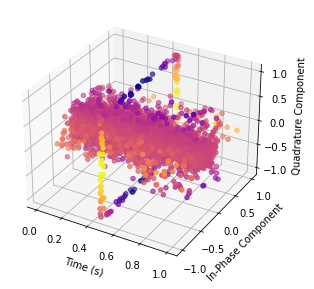

In [5]:
ax = plt.axes(projection='3d')

times = np.array([i/len(buffer) for i in range(len(buffer))])
samples = np.random.choice(len(buffer), int(len(buffer)/80))
#samples = range(len(buffer))

ax.scatter3D(
    times[samples], 
    buffer.real[samples], 
    buffer.imag[samples], 
    c=np.square(buffer[samples]), 
    cmap='plasma',
)
ax.set_xlabel('Time (s)')
ax.set_ylabel('In-Phase Component')
ax.set_zlabel('Quadrature Component')
#plt.xlim((0.44, 0.45))

plt.tight_layout()
plt.savefig('fig/analyze_1_iq.pdf')

In [6]:
freqs, times, spectrogram = scipy.signal.spectrogram(
    buffer,
    fs=300000,
    window="hamming",
    nperseg=256,
    noverlap=0,
    return_onesided=False,
    #scaling="spectrum",
)

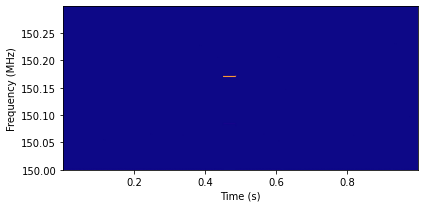

In [7]:
from scipy.fft import fftshift
plt.subplots(figsize=(6, 3))
plt.pcolormesh(
    times,
    [(f+150150000)/1000000 for f in fftshift(freqs)], 
    fftshift(spectrogram, axes=0), 
    shading='gouraud',
    cmap="plasma",
    rasterized=True,
)
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.savefig('fig/analyze_2_spectrogram.pdf')

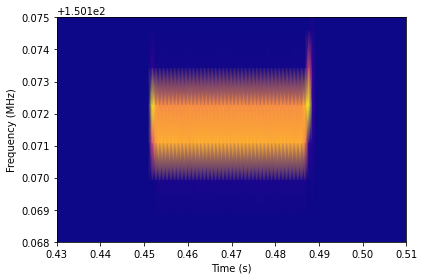

In [8]:
from scipy.fft import fftshift
plt.pcolormesh(
    times,
    [(f+150150000)/1000000 for f in fftshift(freqs)], 
    fftshift(spectrogram, axes=0), 
    shading='gouraud',
    cmap="plasma",
    rasterized=True,
)
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (s)')


plt.ylim((150.168000,150.175000))
plt.xlim((0.43, 0.51))
plt.tight_layout()
plt.savefig('fig/analyze_3_spectrogram_detail.pdf')

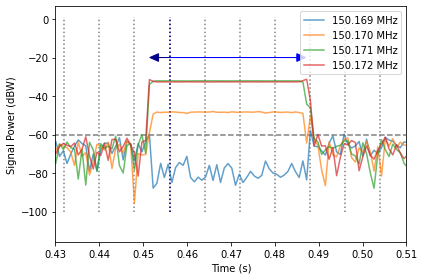

In [9]:
plt.xlabel('Time (s)')
plt.ylabel('Signal Power (dBW)')

for i, (power, freq, time) in enumerate(zip(spectrogram, freqs, times)):
    freq_mhz = (150150000 + freq) / 1000 / 1000
    if freq_mhz < 150.168 or freq_mhz > 150.173:
        continue
    x = [i * 256 / 300000 for i in range(len(power))]
    y = [10 * np.log10(p) for p in power]
    plt.plot(x, y, label=f"{freq_mhz:.3f} MHz", alpha=0.7)

plt.legend()

plt.hlines([-60], xmin=0, xmax=1, color="grey", linestyle="dashed")
plt.vlines(np.arange(0.0, 1.0, 0.008), ymin=-100, ymax=1, color="grey", linestyle="dotted")

plt.vlines([0.456], ymin=-100, ymax=1, color="darkblue", linestyle="dotted")

plt.arrow(0.456, -20, 0.029, 0,
         head_width=4, head_length=0.002, color="blue")
plt.arrow(0.456, -20, -0.0025, 0, 
         head_width=4, head_length=0.002, color="darkblue")

plt.legend()
    
plt.xlim((0.43, 0.51))
plt.tight_layout()
plt.savefig('fig/analyze_4_power.pdf')

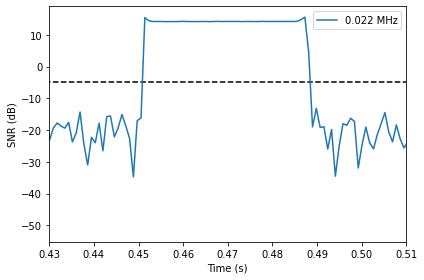

In [10]:
plt.xlabel('Time (s)')
plt.ylabel('SNR (dB)')

power, freq, bin = list(zip(spectrogram, freqs, times))[19]
    
x = [i * 256 / 300000 for i in range(len(power))]
y = [10 * np.log10(p) for p in power]

freq_avg = np.mean(power)
snr = [10 * np.log10(p / freq_avg) for p in power]
plt.plot(x, snr, label=f"{freq/1000/1000:.3f} MHz")


plt.hlines([-5], xmin=0, xmax=1, color="black", linestyle="dashed")
    
plt.legend()
plt.xlim((0.43, 0.51))
plt.tight_layout()
plt.savefig('fig/analyze_5_snr.pdf')